## Employee Attrition Prediction Project

In [3]:
%load_ext autoreload
%autoreload 2

In [70]:
import os
import kagglehub
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame
from typing import  Optional
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
import feature_engine.selection  as fs
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency
from sklearn.metrics import roc_auc_score
from tqdm.notebook import tqdm

In [123]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_curve, 
    roc_auc_score,
   precision_recall_curve
   
   

)
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


#### Data Preparation

In [5]:
def load_data(file_path: str,sep:str=None) -> Optional[DataFrame]:
    '''
    Load the dataset from a local file
    Args:
        - file_path: str: path to the file
        - sep: str: separator used in the file
    Returns:
        - Optional[DataFrame]: A pandas Dataframe contains the loaded dataset
    '''
    try:
        df = pd.read_csv(file_path,sep=sep)
        return df
    except Exception as e:
        print(f"Error: {e}")
        return None 

In [6]:
data = load_data('../data/WA_Fn-UseC_-HR-Employee-Attrition.csv',sep=',')

In [7]:
data.head().T

,0,1,2,3,4
Age,41,49,37,33,27
Attrition,Yes,No,Yes,No,No
BusinessTravel,Travel_Rarely,Travel_Frequently,Travel_Rarely,Travel_Frequently,Travel_Rarely
DailyRate,1102,279,1373,1392,591
Department,Sales,Research & Development,Research & Development,Research & Development,Research & Development
DistanceFromHome,1,8,2,3,2
Education,2,1,2,4,1
EducationField,Life Sciences,Life Sciences,Other,Life Sciences,Medical
EmployeeCount,1,1,1,1,1
EmployeeNumber,1,2,4,5,7


In [8]:
data.shape

(1470, 35)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [10]:
data.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [11]:
def standardizing_column_names(data: DataFrame) -> DataFrame:
  ''' standardize columns names to lower case and replace spaces with underscores
      Args:
          data: DataFrame
      Returns:
          DataFrame
  
  '''
  data.columns = data.columns.str.lower().str.replace(' ', '_')
  return data

In [12]:
# test the function
data = standardizing_column_names(data)
data.columns

Index(['age', 'attrition', 'businesstravel', 'dailyrate', 'department',
       'distancefromhome', 'education', 'educationfield', 'employeecount',
       'employeenumber', 'environmentsatisfaction', 'gender', 'hourlyrate',
       'jobinvolvement', 'joblevel', 'jobrole', 'jobsatisfaction',
       'maritalstatus', 'monthlyincome', 'monthlyrate', 'numcompaniesworked',
       'over18', 'overtime', 'percentsalaryhike', 'performancerating',
       'relationshipsatisfaction', 'standardhours', 'stockoptionlevel',
       'totalworkingyears', 'trainingtimeslastyear', 'worklifebalance',
       'yearsatcompany', 'yearsincurrentrole', 'yearssincelastpromotion',
       'yearswithcurrmanager'],
      dtype='object')

In [13]:
def rename_observations(data: DataFrame) -> DataFrame:
    ''' 
    This function converts all string values in categorical columns 
    lowercase and replaces spaces with underscores in a DataFrame
    Args:
        data: DataFrame
    Returns:
        DataFrame
    '''
    categorical_columns = data.select_dtypes(include=['object']).columns

    for col in categorical_columns:
        data[col] = data[col].str.lower().str.strip().str.replace(' ', '_')
    return data

In [14]:
#test the function
data = rename_observations(data)
data.head().T

,0,1,2,3,4
age,41,49,37,33,27
attrition,yes,no,yes,no,no
businesstravel,travel_rarely,travel_frequently,travel_rarely,travel_frequently,travel_rarely
dailyrate,1102,279,1373,1392,591
department,sales,research_&_development,research_&_development,research_&_development,research_&_development
distancefromhome,1,8,2,3,2
education,2,1,2,4,1
educationfield,life_sciences,life_sciences,other,life_sciences,medical
employeecount,1,1,1,1,1
employeenumber,1,2,4,5,7


In [15]:
# check for missing values
data.isna().sum()

age                         0
attrition                   0
businesstravel              0
dailyrate                   0
department                  0
distancefromhome            0
education                   0
educationfield              0
employeecount               0
employeenumber              0
environmentsatisfaction     0
gender                      0
hourlyrate                  0
jobinvolvement              0
joblevel                    0
jobrole                     0
jobsatisfaction             0
maritalstatus               0
monthlyincome               0
monthlyrate                 0
numcompaniesworked          0
over18                      0
overtime                    0
percentsalaryhike           0
performancerating           0
relationshipsatisfaction    0
standardhours               0
stockoptionlevel            0
totalworkingyears           0
trainingtimeslastyear       0
worklifebalance             0
yearsatcompany              0
yearsincurrentrole          0
yearssince

In [16]:
# check for duplicated rows
data.duplicated().sum()

0

### Removing redundant features 

In [17]:
# select categorical  columns( Nominal and Ordinal)
categorical_features = data.select_dtypes(include=['object'])
categorical_features.head()

,attrition,businesstravel,department,educationfield,gender,jobrole,maritalstatus,over18,overtime
0,yes,travel_rarely,sales,life_sciences,female,sales_executive,single,y,yes
1,no,travel_frequently,research_&_development,life_sciences,male,research_scientist,married,y,no
2,yes,travel_rarely,research_&_development,other,male,laboratory_technician,single,y,yes
3,no,travel_frequently,research_&_development,life_sciences,female,research_scientist,married,y,yes
4,no,travel_rarely,research_&_development,medical,male,laboratory_technician,married,y,no


In [18]:
categorical_features.nunique()

attrition         2
businesstravel    3
department        3
educationfield    6
gender            2
jobrole           9
maritalstatus     3
over18            1
overtime          2
dtype: int64

In [19]:
def remove_high_cardinality_columns(data:DataFrame, threshold:int=10):
    """
    Remove high-cardinality categorical columns from a DataFrame.

    Args:
        - data: The DataFrame containing categorical features.
        - threshold (int): The maximum number of unique values a column can have to avoid being removed.

    Returns:
          - pd.DataFrame: A DataFrame with high-cardinality columns removed.
          - list: The list of columns removed.
    """
    high_cardinality = [col for col in data.columns if data[col].nunique() > threshold]
    #df_reduced = data.drop(columns=high_cardinality)
    
    #print(f"Removed {len(high_cardinality)} high-cardinality columns: {high_cardinality}")
    return high_cardinality

In [20]:
# test the function
cardinal_columns = remove_high_cardinality_columns(categorical_features, threshold=10)
cardinal_columns

[]

In [21]:
categorical_features.head()

,attrition,businesstravel,department,educationfield,gender,jobrole,maritalstatus,over18,overtime
0,yes,travel_rarely,sales,life_sciences,female,sales_executive,single,y,yes
1,no,travel_frequently,research_&_development,life_sciences,male,research_scientist,married,y,no
2,yes,travel_rarely,research_&_development,other,male,laboratory_technician,single,y,yes
3,no,travel_frequently,research_&_development,life_sciences,female,research_scientist,married,y,yes
4,no,travel_rarely,research_&_development,medical,male,laboratory_technician,married,y,no


In [22]:

def remove_low_variance_columns(data:DataFrame, threshold:float=0.95):
    """
    Removes low-variance categorical columns from a DataFrame.
    
    Args:
        - data: The input DataFrame.
        - threshold (float): The value above which a feature is considered low variance.

    Returns:
    - pd.DataFrame: The reduced DataFrame with low-variance columns removed.
    """
    if isinstance(data, pd.DataFrame):
        # Identify low-variance columns
        low_variance = [col for col in data.columns if data[col].value_counts(normalize=True).iloc[0] > threshold]
        print(f"Removed {len(low_variance)} low-variance columns: {low_variance}")
        
        # Drop the identified columns
        #df_reduced = data.drop(columns=low_variance)

        return low_variance
    else:
        raise TypeError("Input data must be a pandas DataFrame")

In [23]:
# test the function
low_variance_col = remove_low_variance_columns(categorical_features, threshold=0.95)


Removed 1 low-variance columns: ['over18']


In [24]:
categorical_features = categorical_features.drop(columns=low_variance_col)

##### remove the over18 columns 

In [25]:
categorical_features.head()

,attrition,businesstravel,department,educationfield,gender,jobrole,maritalstatus,overtime
0,yes,travel_rarely,sales,life_sciences,female,sales_executive,single,yes
1,no,travel_frequently,research_&_development,life_sciences,male,research_scientist,married,no
2,yes,travel_rarely,research_&_development,other,male,laboratory_technician,single,yes
3,no,travel_frequently,research_&_development,life_sciences,female,research_scientist,married,yes
4,no,travel_rarely,research_&_development,medical,male,laboratory_technician,married,no


In [26]:
def find_highly_correlated_categorical(data:DataFrame, threshold:float=0.8):
    """
    Identifies highly correlated categorical features in a DataFrame using Cramér's V.

    Parameters:
    - data: DataFrame: The input DataFrame.
    - threshold (float): The Cramér's V threshold above which columns are considered highly correlated.

    Returns:
    - list: A list of tuples containing pairs of highly correlated columns and their Cramér's V value.
    """
    # Function to calculate Cramér's V
    def cramers_v(x, y):
        confusion_matrix = pd.crosstab(x, y)
        chi2 = chi2_contingency(confusion_matrix)[0]
        n = confusion_matrix.sum().sum()
        return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))

    categorical_cols = data.select_dtypes(include="object").columns
    redundant_pairs = []

    for col1 in categorical_cols:
        for col2 in categorical_cols:
            if col1 != col2:
                cramer_value = cramers_v(data[col1], data[col2])
                if cramer_value > threshold:
                    redundant_pairs.append((col1, col2, cramer_value))
    print("\nHighly Correlated Categorical Features:")
    for pair in redundant_pairs:
        print(f"{pair[0]} and {pair[1]}: Cramér's V = {pair[2]:.2f}")
    
    return redundant_pairs

In [27]:
high_corr_cate = find_highly_correlated_categorical(categorical_features, threshold=0.8)


Highly Correlated Categorical Features:
department and jobrole: Cramér's V = 0.94
jobrole and department: Cramér's V = 0.94


In [28]:
# Drop one of the highly correlated columns
categorical_features.drop(columns=['jobrole'], inplace=True)


In [29]:
categorical_features.head()

,attrition,businesstravel,department,educationfield,gender,maritalstatus,overtime
0,yes,travel_rarely,sales,life_sciences,female,single,yes
1,no,travel_frequently,research_&_development,life_sciences,male,married,no
2,yes,travel_rarely,research_&_development,other,male,single,yes
3,no,travel_frequently,research_&_development,life_sciences,female,married,yes
4,no,travel_rarely,research_&_development,medical,male,married,no


### Data labeling with `One-Hot` and `LabelEncoder` for nominal and ordinal categorical data respectively.

In [30]:
def label_encode_categorical(data:DataFrame):
    """
    Encode categorical columns with numerical values using Label Encoding.
    
    Args:
        - data: The input DataFrame.
    
    Returns:
        - pd.DataFrame: The DataFrame with categorical columns encoded as numerical values.
    """
    label_enc = LabelEncoder()
    for col in data.select_dtypes(include='object').columns:
        data[col] = label_enc.fit_transform(data[col])
    return data

In [31]:
categorical_features = label_encode_categorical(categorical_features)

In [32]:
df_categorical = categorical_features.copy()
df_categorical.head()

,attrition,businesstravel,department,educationfield,gender,maritalstatus,overtime
0,1,2,2,1,0,2,1
1,0,1,1,1,1,1,0
2,1,2,1,4,1,2,1
3,0,1,1,1,0,1,1
4,0,2,1,3,1,1,0


In [33]:
df_categorical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   attrition       1470 non-null   int64
 1   businesstravel  1470 non-null   int64
 2   department      1470 non-null   int64
 3   educationfield  1470 non-null   int64
 4   gender          1470 non-null   int64
 5   maritalstatus   1470 non-null   int64
 6   overtime        1470 non-null   int64
dtypes: int64(7)
memory usage: 80.5 KB


In [34]:
df_categorical.to_csv('../data/categorical_data.csv', index=False)


In [35]:
numerical_features = data.select_dtypes(include=[np.number])
numerical_features.head()

,age,dailyrate,distancefromhome,education,employeecount,employeenumber,environmentsatisfaction,hourlyrate,jobinvolvement,joblevel,...,relationshipsatisfaction,standardhours,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager
0,41,1102,1,2,1,1,2,94,3,2,...,1,80,0,8,0,1,6,4,0,5
1,49,279,8,1,1,2,3,61,2,2,...,4,80,1,10,3,3,10,7,1,7
2,37,1373,2,2,1,4,4,92,2,1,...,2,80,0,7,3,3,0,0,0,0
3,33,1392,3,4,1,5,4,56,3,1,...,3,80,0,8,3,3,8,7,3,0
4,27,591,2,1,1,7,1,40,3,1,...,4,80,1,6,3,3,2,2,2,2


In [36]:
len(numerical_features.columns)

26

In [37]:
numerical_features.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1470.0,36.923810,9.135373,18.0,30.00,36.0,43.00,60.0
dailyrate,1470.0,802.485714,403.509100,102.0,465.00,802.0,1157.00,1499.0
distancefromhome,1470.0,9.192517,8.106864,1.0,2.00,7.0,14.00,29.0
education,1470.0,2.912925,1.024165,1.0,2.00,3.0,4.00,5.0
employeecount,1470.0,1.000000,0.000000,1.0,1.00,1.0,1.00,1.0
employeenumber,1470.0,1024.865306,602.024335,1.0,491.25,1020.5,1555.75,2068.0
environmentsatisfaction,1470.0,2.721769,1.093082,1.0,2.00,3.0,4.00,4.0
hourlyrate,1470.0,65.891156,20.329428,30.0,48.00,66.0,83.75,100.0
jobinvolvement,1470.0,2.729932,0.711561,1.0,2.00,3.0,3.00,4.0
joblevel,1470.0,2.063946,1.106940,1.0,1.00,2.0,3.00,5.0


In [38]:
corr_matrix = numerical_features.corr()
corr_matrix

,age,dailyrate,distancefromhome,education,employeecount,employeenumber,environmentsatisfaction,hourlyrate,jobinvolvement,joblevel,...,relationshipsatisfaction,standardhours,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager
age,1.000000,0.010661,-0.001686,0.208034,NaN,-0.010145,0.010146,0.024287,0.029820,0.509604,...,0.053535,NaN,0.037510,0.680381,-0.019621,-0.021490,0.311309,0.212901,0.216513,0.202089
dailyrate,0.010661,1.000000,-0.004985,-0.016806,NaN,-0.050990,0.018355,0.023381,0.046135,0.002966,...,0.007846,NaN,0.042143,0.014515,0.002453,-0.037848,-0.034055,0.009932,-0.033229,-0.026363
distancefromhome,-0.001686,-0.004985,1.000000,0.021042,NaN,0.032916,-0.016075,0.031131,0.008783,0.005303,...,0.006557,NaN,0.044872,0.004628,-0.036942,-0.026556,0.009508,0.018845,0.010029,0.014406
education,0.208034,-0.016806,0.021042,1.000000,NaN,0.042070,-0.027128,0.016775,0.042438,0.101589,...,-0.009118,NaN,0.018422,0.148280,-0.025100,0.009819,0.069114,0.060236,0.054254,0.069065
employeecount,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
employeenumber,-0.010145,-0.050990,0.032916,0.042070,NaN,1.000000,0.017621,0.035179,-0.006888,-0.018519,...,-0.069861,NaN,0.062227,-0.014365,0.023603,0.010309,-0.011240,-0.008416,-0.009019,-0.009197
environmentsatisfaction,0.010146,0.018355,-0.016075,-0.027128,NaN,0.017621,1.000000,-0.049857,-0.008278,0.001212,...,0.007665,NaN,0.003432,-0.002693,-0.019359,0.027627,0.001458,0.018007,0.016194,-0.004999
hourlyrate,0.024287,0.023381,0.031131,0.016775,NaN,0.035179,-0.049857,1.000000,0.042861,-0.027853,...,0.001330,NaN,0.050263,-0.002334,-0.008548,-0.004607,-0.019582,-0.024106,-0.026716,-0.020123
jobinvolvement,0.029820,0.046135,0.008783,0.042438,NaN,-0.006888,-0.008278,0.042861,1.000000,-0.012630,...,0.034297,NaN,0.021523,-0.005533,-0.015338,-0.014617,-0.021355,0.008717,-0.024184,0.025976
joblevel,0.509604,0.002966,0.005303,0.101589,NaN,-0.018519,0.001212,-0.027853,-0.012630,1.000000,...,0.021642,NaN,0.013984,0.782208,-0.018191,0.037818,0.534739,0.389447,0.353885,0.375281


In [39]:

def remove_highly_correlated_features(data:DataFrame, threshold:float=0.8):
    """
    Removes highly correlated features from a numerical DataFrame.
    Args:
        data (DataFrame): The input numerical DataFrame.
        threshold (float): The correlation threshold above which features are dropped.

    Returns:
        pd.DataFrame: The reduced DataFrame with less correlated features.
        list: A list of the features that were dropped.
    """
    if not isinstance(data, pd.DataFrame):
        raise TypeError("Input data must be a pandas DataFrame.")

    # Compute the correlation matrix
    corr_matrix = data.corr()

    # Upper triangle of the correlation matrix
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Identify features to drop
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column].abs() > threshold)]

    # Drop highly correlated features
    #reduced_data = data.drop(columns=to_drop)

    return to_drop

In [40]:
high_corr_num = remove_highly_correlated_features(numerical_features, threshold=0.8)
high_corr_num

['monthlyincome']

In [41]:
numerical_features = numerical_features.drop(columns=high_corr_num)

In [42]:
# test the function
low_variance_num_col = remove_low_variance_columns(numerical_features, threshold=0.95)


Removed 2 low-variance columns: ['employeecount', 'standardhours']


In [43]:
numerical_features = numerical_features.drop(columns=low_variance_num_col)

In [44]:
numerical_features.to_csv('../data/numerical_data.csv', index=False)

In [65]:
processed_data = pd.concat([df_categorical, numerical_features], axis=1)

# Save the processed data to a `preprocessed_data.csv` file

In [ ]:

processed_data.to_csv('../data/preprocessed_data.csv', index=False)


#### Model Selection,Training and Evaluation.

### Decision Tree

In [72]:
df = pd.read_csv('../data/preprocessed_data.csv')

In [73]:
df.head()

,attrition,businesstravel,department,educationfield,gender,maritalstatus,overtime,age,dailyrate,distancefromhome,...,performancerating,relationshipsatisfaction,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager
0,1,2,2,1,0,2,1,41,1102,1,...,3,1,0,8,0,1,6,4,0,5
1,0,1,1,1,1,1,0,49,279,8,...,4,4,1,10,3,3,10,7,1,7
2,1,2,1,4,1,2,1,37,1373,2,...,3,2,0,7,3,3,0,0,0,0
3,0,1,1,1,0,1,1,33,1392,3,...,3,3,0,8,3,3,8,7,3,0
4,0,2,1,3,1,1,0,27,591,2,...,3,4,1,6,3,3,2,2,2,2


In [48]:
df.shape

(1470, 30)

In [78]:

def split_and_prepare_data(df:DataFrame, target_column:str, test_size:float=0.3, random_state:int=1):
    """
    Splits the dataset into training and testing sets, separates the target column, 
    and resets the index.

    Args:
        df: The input DataFrame.
        target_column (str): The name of the target column.
        test_size (float): The proportion of the dataset to include in the test split.
        random_state (int): Random seed for reproducibility.

    Returns:
        pd.DataFrame: X_train (features for training).
        pd.DataFrame: X_test (features for testing).
        np.ndarray: y_train (target values for training).
        np.ndarray: y_test (target values for testing).
    """
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input data must be a pandas DataFrame.")
    
    if target_column not in df.columns:
        raise ValueError(f"The target column '{target_column}' is not in the DataFrame.")

    # Split the dataset into training and testing sets
    X_train, X_test = train_test_split(df, test_size=test_size, random_state=random_state)

    # Reset the index for both splits
    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)

    # Extract target values
    y_train = X_train[target_column].values
    y_test = X_test[target_column].values

    # Remove the target column from features
    X_train = X_train.drop(columns=[target_column])
    X_test = X_test.drop(columns=[target_column])

    return X_train, X_test, y_train, y_test

In [79]:
X_train, X_test, y_train, y_test = split_and_prepare_data(df, target_column="attrition", test_size=0.3, random_state=1)

In [86]:
def train_and_evaluate(X_train, X_test, y_train, y_test):
    '''Train a Decision Tree Classifier and evaluate its performance using the test data.
    Args:
        X_train: pd.DataFrame: The features for training.
        X_test: pd.DataFrame: The features for testing.
        y_train: np.ndarray: The target values for training.
        y_test: np.ndarray: The target values for testing.
    Returns:
        DecisionTreeClassifier: The trained Decision Tree model.
        '''
    # Train Decision Tree Classifier
    model = DecisionTreeClassifier(max_depth=3,random_state=1)
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Evaluate metrics
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba):.2f}")

    
    
    return model

In [87]:
train_and_evaluate(X_train, X_test, y_train, y_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.98      0.90       364
           1       0.50      0.10      0.17        77

    accuracy                           0.83       441
   macro avg       0.67      0.54      0.54       441
weighted avg       0.78      0.83      0.77       441

Confusion Matrix:
[[356   8]
 [ 69   8]]
ROC-AUC Score: 0.72


DecisionTreeClassifier(max_depth=3, random_state=1)

- The model achieves an accuracy of `0.83`, but the `recall` and `F1-score` for the minority `class (1)` are notably low, highlighting its difficulty in accurately identifying minority class samples.
- To address this class imbalance and enhance performance on the minority class, I employed `SMOTE (Synthetic Minority Oversampling Technique)` to generate synthetic samples, improving the model’s ability to recognize these instances.

In [ ]:
best_model = tune_hyperparameters(X_train, y_train)

Best Parameters: {'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 10}


In [52]:
base_model = train_and_evaluate(X_train, X_test, y_train, y_test)
base_model

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.98      0.90       364
           1       0.50      0.10      0.17        77

    accuracy                           0.83       441
   macro avg       0.67      0.54      0.54       441
weighted avg       0.78      0.83      0.77       441

Confusion Matrix:
[[356   8]
 [ 69   8]]
ROC-AUC Score: 0.72


DecisionTreeClassifier(max_depth=3, random_state=1)

#### lets improve the imbalance

In [89]:
def split_and_balance_data(df, target_column, test_size=0.3, random_state=1):
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    # Apply SMOTE for oversampling the minority class
    smote = SMOTE(random_state=random_state)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

    return X_train_balanced, X_test, y_train_balanced, y_test

In [90]:
def train_model_with_class_weight(X_train, X_test, y_train, y_test):
    # Decision Tree with class weight
    clf = DecisionTreeClassifier(class_weight='balanced', max_depth=3,random_state=1)
    clf.fit(X_train, y_train)

    # Predictions and Evaluation
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]

    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba):.2f}")

    return clf

In [91]:
X_train, X_test, y_train, y_test = split_and_balance_data(df, target_column="attrition", test_size=0.3, random_state=1)

In [92]:
balance_model = train_model_with_class_weight(X_train, X_test, y_train, y_test)
balance_model

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.73      0.80       364
           1       0.30      0.56      0.39        77

    accuracy                           0.70       441
   macro avg       0.59      0.64      0.59       441
weighted avg       0.78      0.70      0.73       441

Confusion Matrix:
[[264 100]
 [ 34  43]]
ROC-AUC Score: 0.71


DecisionTreeClassifier(class_weight='balanced', max_depth=3, random_state=1)

### Use hyperparameter fine tuning
      - max_depth
      - min_samples_split
      - min_samples_leaf

In [93]:
def tune_hyperparameters(X_train:DataFrame,y_train:np.ndarray):
    '''perform hyperparameter tuning for a DecisionTreeClassifier using GridSearchCV
    Args:
        X_train: pd.DataFrame: The features for training.
        y_train: np.ndarray: The target values for training.
    Returns:
        DecisionTreeClassifier: The best trained Decision Tree model.
    '''

    param_grid = {
        'max_depth': [1,2,3, 4,5,6, 10,15,20, None],
        'min_samples_split': [3, 5, 10,15,20,50,100,200],
        'min_samples_leaf': [3, 6, 9,12,15]
    }
    
    # Grid Search
    param_grid = {
        'criterion': ['gini', 'entropy', 'log_loss'],
        'max_depth': [1, 2, 3, 4, 5, 10, 15, None],
        'min_samples_split': [3, 5, 10, 15, 20, 50],
        'min_samples_leaf': [1, 3, 5, 10, 20]
    }
    model = DecisionTreeClassifier(random_state=1)
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='f1',  # Focus on F1 score
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    print("Starting hyperparameter tuning...")
    grid_search.fit(X_train, y_train)
    print("\nHyperparameter tuning completed.")
    print("Best Parameters:", grid_search.best_params_)
    print(f"Best F1 Score: {grid_search.best_score_:.4f}")

    return grid_search.best_estimator_


In [101]:
tune_hyperparameters(X_train, y_train)

Starting hyperparameter tuning...
Fitting 5 folds for each of 720 candidates, totalling 3600 fits

Hyperparameter tuning completed.
Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 3}
Best F1 Score: 0.8096


DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=3,
                       random_state=1)

In [102]:
def split_and_balance_data(df, target_column, test_size=0.3, random_state=1):
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    # Apply SMOTE for oversampling the minority class
    smote = SMOTE(random_state=random_state)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

    return X_train_balanced, X_test, y_train_balanced, y_test

In [103]:
X_train_b, X_test_b, y_train_b, y_test_b = split_and_balance_data(df, target_column="attrition", test_size=0.3, random_state=1)

In [104]:
def train_model_with_class_weight(X_train, X_test, y_train, y_test):
    # Decision Tree with class weight
    clf = DecisionTreeClassifier(class_weight='balanced', criterion='gini',max_depth=10,min_samples_leaf=5,min_samples_split=3,random_state=1)
    clf.fit(X_train, y_train)

    # Predictions and Evaluation
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]
    
    # Evaluate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')  # For binary classification
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    cm = confusion_matrix(y_test, y_pred)

    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba):.2f}")

    return clf

In [105]:
tune_model = train_model_with_class_weight(X_train_b, X_test_b, y_train_b, y_test_b)
tune_model

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.83      0.84       364
           1       0.31      0.36      0.33        77

    accuracy                           0.75       441
   macro avg       0.58      0.60      0.59       441
weighted avg       0.76      0.75      0.75       441

Confusion Matrix:
[[301  63]
 [ 49  28]]
ROC-AUC Score: 0.62


DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=5, min_samples_split=3, random_state=1)

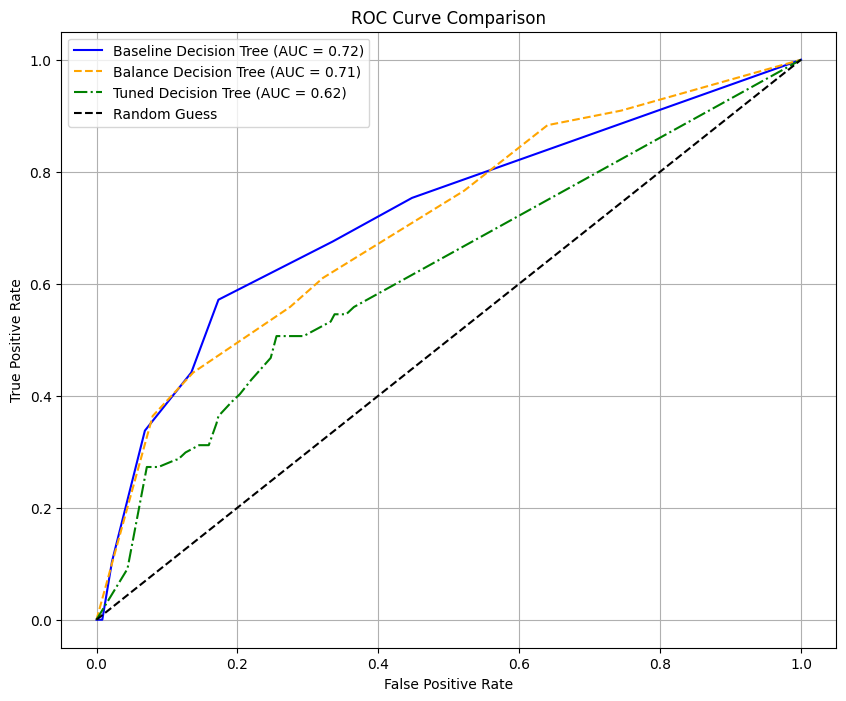

In [108]:
def plot_roc_comparison(models, X_test, y_test, labels):
    """
    Plot ROC curve comparison for multiple models with better visual distinction.
    """
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'orange', 'green'] 
    line_styles = ['-', '--', '-.']  

    for model, label, color, style in zip(models, labels, colors, line_styles):
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = roc_auc_score(y_test, y_proba)
        plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})', color=color, linestyle=style)

    # Random Guess Line
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")

    # Add labels, title, and legend
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve Comparison")
    plt.legend()
    plt.grid()
    plt.show()

# Example usage
models = [base_model, balance_model, tune_model]  # Replace with actual models
labels = ["Baseline Decision Tree", "Balance Decision Tree", "Tuned Decision Tree"]
plot_roc_comparison(models, X_test, y_test, labels)

1.Baseline Decision Tree (AUC = 0.72):

		- Performs slightly better compared to the other two models.
		- Indicates a decent ability to distinguish between the positive and negative classes.
  
2.Balanced Decision Tree (AUC = 0.71):

		- Close in performance to the baseline but slightly lower.
		- Incorporating class weights (class_weight='balanced') has improved performance for the minority class without compromising too much on overall accuracy.
  
3.Tuned Decision Tree (AUC = 0.62):

		- Performs worse than both the baseline and balanced models.
		- Suggests that the hyperparameter tuning may not have effectively addressed the trade-offs, possibly overfitting or not being suited to the dataset.

### Random Forest

In [112]:
def train_random_forest(X_train, X_test, y_train, y_test):
    # Initialize and train the model
    model = RandomForestClassifier(class_weight="balanced", random_state=1)
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Evaluate the model
    print("\n--- Random Forest Model Evaluation ---")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba):.2f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    
    return model, y_proba

In [113]:
model_rf, y_proba_rf = train_random_forest(X_train_b, X_test_b, y_train_b, y_test_b)


--- Random Forest Model Evaluation ---
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.94      0.90       364
           1       0.55      0.36      0.44        77

    accuracy                           0.84       441
   macro avg       0.71      0.65      0.67       441
weighted avg       0.82      0.84      0.82       441

ROC-AUC Score: 0.77
Confusion Matrix:
 [[341  23]
 [ 49  28]]


**Class Imbalance:**

   - Class 0 (majority class) has 364 samples, while class 1 (minority class) has only 77 samples.
  
   - This leads to the model being biased toward class 0, as seen in high recall and F1-score for class 0 but low scores for class 1.

**Low Recall for Class 1:** Only 36% of actual positive samples (class 1) are detected correctly.

### Hyperparameter tuning

In [114]:
def tune_random_forest(X_train, y_train):
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None]
    }
    rf = RandomForestClassifier(class_weight="balanced", random_state=1)
    grid_search = GridSearchCV(rf, param_grid, scoring='f1', cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print("Best Parameters:", grid_search.best_params_)
    return grid_search.best_estimator_


In [119]:
def adjust_threshold(y_test, y_proba):
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold = thresholds[np.argmax(f1_scores)]

    print(f"Best Threshold for F1-Score: {best_threshold:.2f}")
    return best_threshold

In [120]:
def evaluate_model_with_threshold(model, X_test, y_test, y_proba, threshold):
    y_pred_threshold = (y_proba >= threshold).astype(int)

    print("\nModel Evaluation with Adjusted Threshold:")
    print(classification_report(y_test, y_pred_threshold))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred_threshold))
    print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba):.2f}")

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.2f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

In [115]:

X_train, X_test, y_train, y_test = split_and_balance_data(df, target_column="attrition", test_size=0.3, random_state=1)

In [117]:
# Hyperparameter tuning
best_rf_model = tune_random_forest(X_train, y_train)

Best Parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


Best Threshold for F1-Score: 0.40

Model Evaluation with Adjusted Threshold:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89       364
           1       0.48      0.60      0.53        77

    accuracy                           0.82       441
   macro avg       0.70      0.73      0.71       441
weighted avg       0.84      0.82      0.83       441

Confusion Matrix:
[[315  49]
 [ 31  46]]
ROC-AUC Score: 0.78


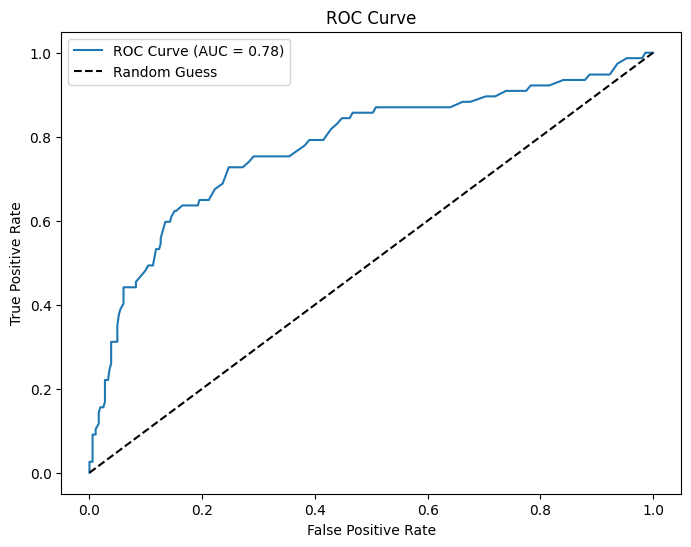

In [122]:

# Re-train the best model and get probabilities
best_rf_model.fit(X_train, y_train)
y_proba_best = best_rf.predict_proba(X_test)[:, 1]

# Adjust threshold
optimal_threshold = adjust_threshold(y_test, y_proba_best)

# Evaluate with adjusted threshold
evaluate_model_with_threshold(best_rf_model, X_test, y_test, y_proba_best, optimal_threshold)

In [124]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [None, 10, 15,20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# RandomizedSearchCV
rf = RandomForestClassifier(class_weight="balanced", random_state=1)
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=50,  # Number of parameter combinations to try
    scoring='f1',
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=1
)
random_search.fit(X_train, y_train)

# Best parameters and model
best_rf_model = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_est

Best Threshold for F1-Score: 0.41

Model Evaluation with Adjusted Threshold:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89       364
           1       0.48      0.58      0.53        77

    accuracy                           0.82       441
   macro avg       0.69      0.72      0.71       441
weighted avg       0.83      0.82      0.82       441

Confusion Matrix:
[[315  49]
 [ 32  45]]
ROC-AUC Score: 0.78


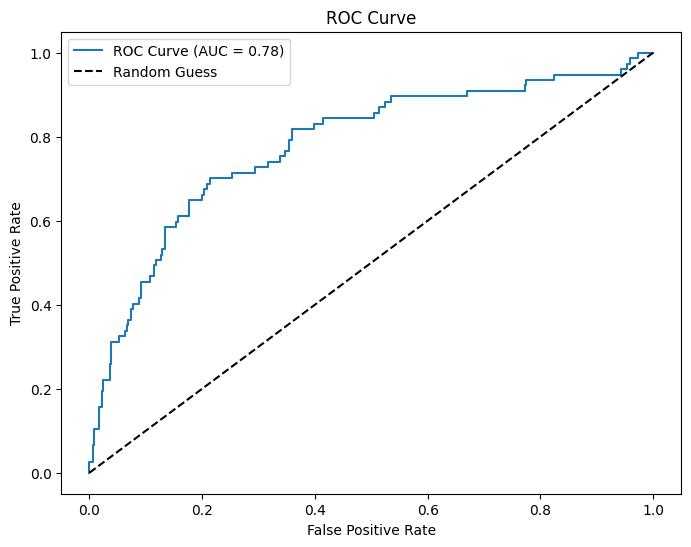

In [125]:
# Predict probabilities and adjust threshold
y_proba_best = best_rf_model.predict_proba(X_test)[:, 1]
optimal_threshold = adjust_threshold(y_test, y_proba_best)

# Evaluate with adjusted threshold
evaluate_model_with_threshold(best_rf_model, X_test, y_test, y_proba_best, optimal_threshold)


### Gradient Boosting

In [130]:
from sklearn.metrics import classification_report, roc_auc_score
from xgboost import XGBClassifier
def evaluate_xgboost(X_train, y_train, X_test, y_test, scale_pos_weight=5, best_threshold=0.5, random_state=1):
    """
    Train and evaluate an XGBoost classifier with the given parameters.

    Parameters:
        X_train (array-like): Training features.
        y_train (array-like): Training labels.
        X_test (array-like): Test features.
        y_test (array-like): Test labels.
        scale_pos_weight (float): Weight for balancing positive and negative classes.
        best_threshold (float): Threshold for converting probabilities to class predictions.
        random_state (int): Random seed for reproducibility.

    Returns:
        dict: Evaluation results including model, classification report, and ROC-AUC score.
    """
    # Initialize and train the XGBoost model
    xgb = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=random_state)
    xgb.fit(X_train, y_train)

    # Predict probabilities and convert them to final predictions
    y_test_proba = xgb.predict_proba(X_test)[:, 1]
    y_test_final = (y_test_proba > best_threshold).astype(int)

    # Evaluate the model
    print("\nXGBoost Evaluation with Adjusted Threshold:")
    class_report = classification_report(y_test, y_test_final)
    roc_auc = roc_auc_score(y_test, y_test_proba)
    print(class_report)
    print(f"ROC-AUC Score: {roc_auc:.2f}")

    # Return the trained model and evaluation metrics
    return {
        "model": xgb,
        "classification_report": class_report,
        "roc_auc_score": roc_auc
    }

In [131]:
results = evaluate_xgboost(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,  # Use test set
    y_test=y_test,  # Use test labels
    scale_pos_weight=5,
    best_threshold=0.5,
    random_state=1
)


XGBoost Evaluation with Adjusted Threshold:
              precision    recall  f1-score   support

           0       0.87      0.88      0.87       364
           1       0.39      0.36      0.38        77

    accuracy                           0.79       441
   macro avg       0.63      0.62      0.62       441
weighted avg       0.78      0.79      0.79       441

ROC-AUC Score: 0.76


### Parameter tunning for xgboost

In [158]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

#Load your data
X = df.drop(columns=['attrition'])  # Features
y = df['attrition']  # Target

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', eval_metric='auc')

# Define hyperparameters to tune
param_grid = {
    'eta': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'n_estimators': [50, 100, 150],
    'gamma': [0, 0.1, 0.2],
    'scale_pos_weight': [1, 2, 5]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='roc_auc', cv=3, verbose=1, n_jobs=-1)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Get the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the model
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Best Parameters: {best_params}")
print(f"Best ROC-AUC Score: {roc_auc:.2f}")

Fitting 3 folds for each of 11664 candidates, totalling 34992 fits


KeyboardInterrupt: 

In [ ]:
def train_xgboost_with_params(X_train, y_train, X_test, y_test, best_threshold=0.5, num_boost_round=175):
    """
    Train and evaluate an XGBoost model using specified parameters.

    Parameters:
        X_train (array-like): Training features.
        y_train (array-like): Training labels.
        X_test (array-like): Test features.
        y_test (array-like): Test labels.
        best_threshold (float): Threshold for converting probabilities to class predictions.
        num_boost_round (int): Number of boosting rounds.

    Returns:
        dict: Evaluation results including model, classification report, and ROC-AUC score.
    """
    import xgboost as xgb
    from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


    # Convert to DMatrix format
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Define model parameters
    xgb_params = {
        'eta': 0.3,                
        'max_depth': 3,          
        'min_child_weight': 1,  
        'objective': 'binary:logistic',
        'eval_metric': 'auc',     
        'nthread': 8,            
        'seed': 1,               
        'verbosity': 1
    }

    # Train the model
    model = xgb.train(
        params=xgb_params,
        dtrain=dtrain,
        num_boost_round=num_boost_round
    )

    # Predict probabilities and apply threshold
    y_proba = model.predict(dtest)
    y_pred = (y_proba > best_threshold).astype(int)

    # Evaluate the model
    print("\n--- XGBoost Model Evaluation ---")
    class_report = classification_report(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Classification Report:")
    print(class_report)
    print(f"ROC-AUC Score: {roc_auc:.2f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    # Return the trained model and evaluation metrics
    return {
        "model": model,
        "classification_report": class_report,
        "roc_auc_score": roc_auc,
        "confusion_matrix": conf_matrix
    }

In [156]:

results = train_xgboost_with_params(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    best_threshold=0.5,
    num_boost_round=175  
)


--- XGBoost Model Evaluation ---
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       380
           1       0.50      0.28      0.36        61

    accuracy                           0.86       441
   macro avg       0.70      0.62      0.64       441
weighted avg       0.84      0.86      0.84       441

ROC-AUC Score: 0.78
Confusion Matrix:
[[363  17]
 [ 44  17]]


### Selecting the final model
- Choosing between `xgboost`, `random forest` and `decision tree`
- Training the final model
- Saving the model